# Cover Type Prediction of Forests
## Introduction
This kaggle competition is a multiclass classification problem. We have 7 classes to predict, with continuous and categorical features.
This notebook was also published as a Kaggle kernel here:
https://www.kaggle.com/radcheb/sd701-chebaane-walkthrough

## Initial import

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

In [3]:
test_csv = "./test-set.csv"
train_csv = "./train-set.csv"

In [4]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)
train_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2611,326,20,120,27,1597,168,214,184,...,0,0,0,0,0,0,0,0,0,6
1,2,2772,324,17,42,7,1814,175,220,183,...,0,0,0,0,0,0,0,0,0,2
2,3,2764,4,14,480,-21,700,201,212,148,...,0,0,0,0,0,0,0,0,0,2
3,4,3032,342,9,60,8,4050,202,227,164,...,0,0,0,0,0,0,0,0,0,2
4,5,2488,23,11,117,21,1117,209,218,151,...,0,0,0,0,0,0,0,0,0,2


In [5]:
features = train_df.drop(["Id", "Cover_Type"], axis=1).columns
X_train, X_val, y_train, y_val = train_test_split(train_df[features], train_df["Cover_Type"], test_size=0.2, random_state=42)

## Features engineering

In [6]:
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_val)
print("Total precision: " + str(1 - np.count_nonzero(y_val - y_pred) / len(y_val - y_pred)))
scores = np.round(precision_score(y_val, y_pred, average=None), 3)
for i in range(0, 7):
    print("    Class {0}: {1}".format(i+1, scores[i]))

#Total precision: 0.9209600544711757
#    Class 1: 0.914
#    Class 2: 0.928
#    Class 3: 0.893
#    Class 4: 0.911
#    Class 5: 0.915
#    Class 6: 0.891
#    Class 7: 0.965

Total precision: 0.921149190497806
    Class 1: 0.914
    Class 2: 0.929
    Class 3: 0.893
    Class 4: 0.885
    Class 5: 0.926
    Class 6: 0.881
    Class 7: 0.961


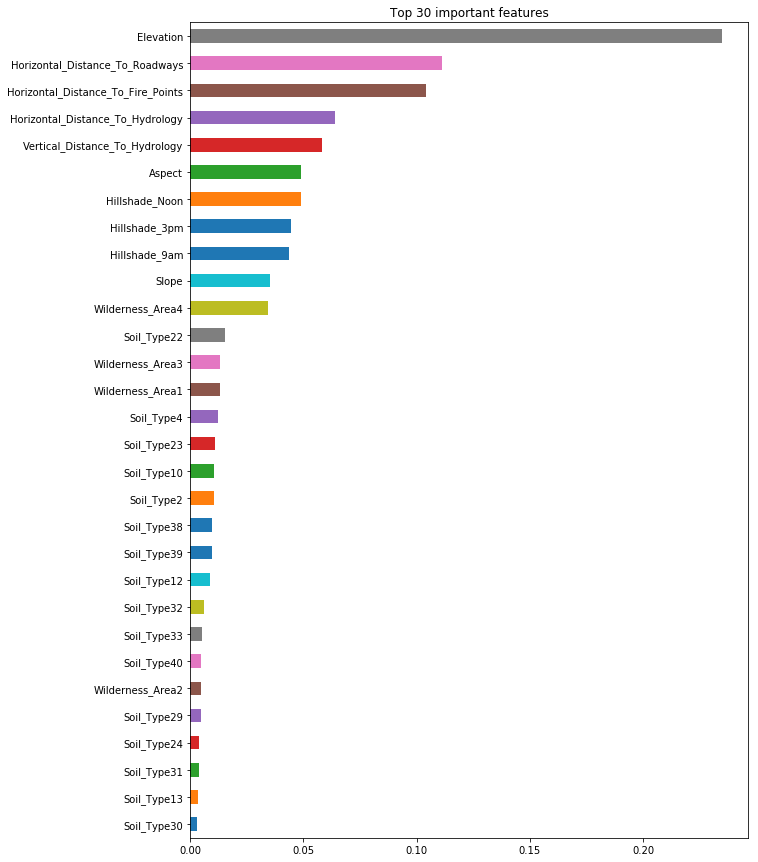

In [7]:
feat_importances = pd.Series(rf_clf.feature_importances_, index=features)
feat_importances.nlargest(30).iloc[::-1].plot(kind='barh', figsize=[10, 15], title="Top 30 important features")

* We notice that **Elevation, Horizontal_Distance_To_Roadways, Horizontal_Distance_To_Fire_Points, Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology** are the most important features so let's generate new features from the mix of these features.
* Also **Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology** are the same mesure from different axes so a better feature may be the hypotenuse of both.
* Finally since we want to use ensemble learning algorithms (such as RandomForest), we need to have consistant features, so we to group all **Soil_TypeXX** columns in one column. Same for **Wilderness_AreaX**. In fact random forest train many small trees based on a subset of the feature, it's no approriate to take some of the **Soil_TypeXX** columnw without the others.

In [75]:
def feature_engineering(in_df):
    
    rs_df = in_df
    
    rs_df['Elev_m_VDH'] = rs_df['Elevation'] - rs_df['Vertical_Distance_To_Hydrology']
         
    rs_df['Elev_p_VDH'] = rs_df['Elevation'] + rs_df['Vertical_Distance_To_Hydrology']
         
    rs_df['Elev_m_HDH'] = rs_df['Elevation'] - rs_df['Horizontal_Distance_To_Hydrology']
         
    rs_df['Elev_p_HDH'] = rs_df['Elevation'] + rs_df['Horizontal_Distance_To_Hydrology']
     
    rs_df['Elev_m_DH'] = rs_df['Elevation'] - rs_df['Dist_to_Hydrolody']
         
    rs_df['Elev_p_DH'] = rs_df['Elevation'] + rs_df['Dist_to_Hydrolody']

    rs_df['Hydro_p_Fire'] = rs_df['Horizontal_Distance_To_Hydrology'] + rs_df['Horizontal_Distance_To_Fire_Points']
     
    rs_df['Hydro_m_Fire'] = rs_df['Horizontal_Distance_To_Hydrology'] - rs_df['Horizontal_Distance_To_Fire_Points']
     
    rs_df['Hydro_p_Road'] = rs_df['Horizontal_Distance_To_Hydrology'] + rs_df['Horizontal_Distance_To_Roadways']
     
    rs_df['Hydro_p_Road'] = rs_df['Horizontal_Distance_To_Hydrology'] - rs_df['Horizontal_Distance_To_Roadways']
     
    rs_df['Fire_p_Road'] = rs_df['Horizontal_Distance_To_Fire_Points'] + rs_df['Horizontal_Distance_To_Roadways']
     
    rs_df['Fire_m_Road'] = rs_df['Horizontal_Distance_To_Fire_Points'] - rs_df['Horizontal_Distance_To_Roadways']
    
    rs_df['Dist_to_Hydrolody'] = (rs_df['Horizontal_Distance_To_Hydrology']**2 + rs_df['Vertical_Distance_To_Hydrology']**2 ) **0.5

    rs_df['Soil'] = 0
    for i in range(1,41):
        rs_df['Soil']= rs_df['Soil'] + i * rs_df['Soil_Type'+str(i)]
        
    rs_df['Wilderness_Area'] = 0
    for i in range(1,5):
        rs_df['Wilderness_Area'] = rs_df['Wilderness_Area'] + i * rs_df['Wilderness_Area'+str(i)]
        
    return rs_df

new_features = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points',
    'Elev_m_VDH', 'Elev_p_VDH', 'Dist_to_Hydrolody', 'Hydro_p_Fire', 'Hydro_m_Fire', 'Hydro_p_Road', 'Hydro_p_Road',
    'Fire_p_Road', 'Fire_m_Road', 'Soil', 'Wilderness_Area', 
    'Elev_m_HDH', 'Elev_p_HDH', 'Elev_m_VDH', 'Elev_p_VDH', 'Elev_m_DH', 'Elev_p_DH']
new_features_df = feature_engineering(train_df)
X_train, X_val, y_train, y_val = train_test_split(new_features_df[new_features], new_features_df["Cover_Type"], test_size=0.2, random_state=42)

In [76]:
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_val)
print("Total precision: " + str(1 - np.count_nonzero(y_val - y_pred) / len(y_val - y_pred)))
scores = np.round(precision_score(y_val, y_pred, average=None), 3)
for i in range(0, 7):
    print("    Class {0}: {1}".format(i+1, scores[i]))
    
#Total precision: 0.939107656226358
#    Class 1: 0.93
#    Class 2: 0.948
#    Class 3: 0.921
#    Class 4: 0.902
#    Class 5: 0.92
#    Class 6: 0.914
#    Class 7: 0.969

Total precision: 0.939107656226358
    Class 1: 0.93
    Class 2: 0.948
    Class 3: 0.921
    Class 4: 0.902
    Class 5: 0.92
    Class 6: 0.914
    Class 7: 0.969


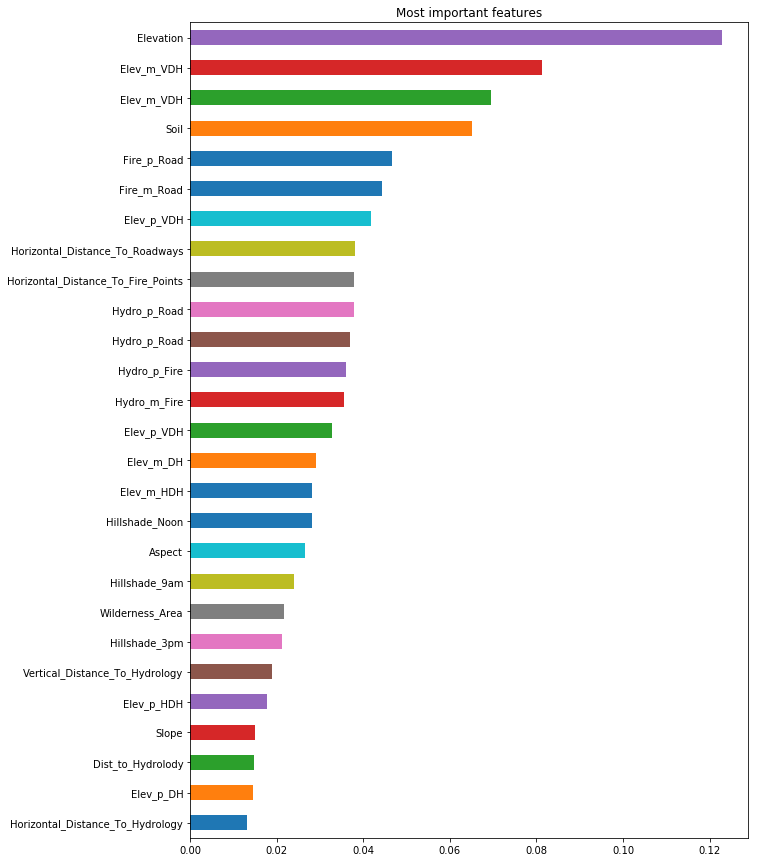

In [67]:
feat_importances = pd.Series(rf_clf.feature_importances_, index=new_features)
feat_importances.nlargest(50).iloc[::-1].plot(kind='barh', figsize=[10, 15], title="Most important features")

### Use ExtraTrees
ExtraTree is Extra Randomized Trees algorithms. It's similar to Random Forest with usually better performance. Here are more details:
https://stats.stackexchange.com/questions/175523/difference-between-random-forest-and-extremely-randomized-trees

In [77]:
et_clf = ExtraTreesClassifier(n_jobs=-1)
et_clf.fit(X_train, y_train)
y_pred = et_clf.predict(X_val)
print("Total precision: " + str(1 - np.count_nonzero(y_val - y_pred) / len(y_val - y_pred)))
scores = np.round(precision_score(y_val, y_pred, average=None), 3)
for i in range(0, 7):
    print("    Class {0}: {1}".format(i+1, scores[i]))
    
#Total precision: 0.9431078831895899
#    Class 1: 0.934
#    Class 2: 0.952
#    Class 3: 0.931
#    Class 4: 0.903
#    Class 5: 0.916
#    Class 6: 0.92
#    Class 7: 0.969

Total precision: 0.9431078831895899
    Class 1: 0.934
    Class 2: 0.952
    Class 3: 0.931
    Class 4: 0.903
    Class 5: 0.916
    Class 6: 0.92
    Class 7: 0.969


### Tune Hyperparameters
Let's make a grid search with 5-folds. We want the best hyperparameter out of this list:
* n_estimators [10, 50, 100, 250, 500, 700, 1000]
* criterion ['gini', 'entropy']
* max_depth [None, 3, 10]
* min_samples_leaf [1, 2, 10]
* max_features [0.3, 0.5, 0.7, 0.9]
* bootstrap [False, True]
* class_weight [None, 'balanced', 'balanced_subsample']

However this my take many time and a lot of memory...

In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100, 250, 500, 700, 1000],
    'max_depth': [None, 3, 10],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [1, 2, 10],
    'max_features' [0.3, 0.5, 0.7, 0.9],
    'bootstrap': [False, True],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

best_model = GridSearchCV(ExtraTreesClassifier(n_jobs=-1, verbose=1), param_grid, cv=5, verbose=10)
best_model.fit(X_train, y_train)

### Final model
The final model is ExtraTreesClassifier with these parameters:
* 900 estimators
* 0.3 features per tree
* Default for other parameters (bootstrap=False, class_weight=None, min_samples_leaf=1, criterion='gini', max_depth=None)

In [82]:
et_clf = ExtraTreesClassifier(n_jobs=-1, max_features=0.5, n_estimators=900, verbose=1)
et_clf.fit(X_train, y_train)
y_pred = et_clf.predict(X_val)
print("Total precision: " + str(1 - np.count_nonzero(y_val - y_pred) / len(y_val - y_pred)))
scores = np.round(precision_score(y_val, y_pred, average=None), 3)
for i in range(0, 7):
    print("    Class {0}: {1}".format(i+1, scores[i]))

#Total precision: 0.952006733242548
#    Class 1: 0.958
#    Class 2: 0.951
#    Class 3: 0.942
#    Class 4: 0.929
#    Class 5: 0.924
#    Class 6: 0.917
#    Class 7: 0.967

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 23.4min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   36.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 900 out of 900 | elapsed:  1.6min finished


Total precision: 0.952006733242548
    Class 1: 0.958
    Class 2: 0.951
    Class 3: 0.942
    Class 4: 0.929
    Class 5: 0.924
    Class 6: 0.917
    Class 7: 0.967


In [ ]:
best_model = ExtraTreesClassifier(max_features=0.5, n_estimators=900, n_jobs=-1, verbose=1)
best_model.fit(new_features_df[new_features], new_features_df["Cover_Type"])

submisson_data = best_model.predict(feature_engineering(test_df)[new_features])
submission_df = pd.DataFrame(np.column_stack([test_df.Id.values, submisson_data]), columns=["Id", "Cover_type"])
submission_df.to_csv("./submission_txx.csv", index=False)
submission_df.head()